In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from py import sqlite_utils as utils

In [2]:
conn = utils.connect_sqlite()

In [18]:
resid_df = utils.execute_sql_query("""
WITH max_versions AS (
    SELECT model_name, MAX(model_ver) AS max_model_ver
    FROM model_predictions
    GROUP BY model_name
), all_preds AS (
    SELECT mp.model_name, mp.hour, mp.pred_value
    FROM model_predictions AS mp 
    JOIN max_versions AS mv
    ON mp.model_name = mv.model_name
    WHERE mp.model_ver = mv.max_model_ver
), train_thre AS (
    SELECT MAX(hour) AS thre
    FROM power_features_train
), resids AS (
    SELECT
        ap.model_name,
        CASE WHEN ap.hour <= (SELECT thre FROM train_thre)
        THEN 'train' ELSE 'test' END AS subset,
        ap.hour,
        pf.y_kw_mean AS gt,
        ap.pred_value AS pred,
        pf.y_kw_mean - ap.pred_value AS resid,
        ABS(pf.y_kw_mean - ap.pred_value) AS abs_resid,
        POWER(pf.y_kw_mean - ap.pred_value, 2) AS sq_resid
    FROM all_preds AS ap
    JOIN power_features AS pf
    ON ap.hour = pf.hour
)
SELECT *
FROM resids
""")
resid_df['hour'] = pd.to_datetime(resid_df['hour'])

### Prediction metrics

In [26]:
metric_df = resid_df.groupby(['model_name', 'subset']).agg(
    n=('resid', 'size'),
    n_nonnull=('resid', 'count'),
    bias=('resid', 'mean'),
    rmse=('sq_resid', lambda arr: np.sqrt(np.mean(arr.dropna()))),
    mae=('abs_resid', 'mean'),
    error_med=('abs_resid', 'median'),
    error_q95=('abs_resid', lambda arr: np.quantile(arr.dropna(), 0.95))
).unstack(level=1).sort_values(('mae', 'test'))
metric_df

n        n_nonnull             bias            \
subset                 test  train      test  train      test     train   
model_name                                                                
catboost_mae           6918  27489      6679  27489  0.022408  0.075995   
baseline_catboost_mae  6918  27489      6679  27489  0.006314  0.069639   
catboost               6918  27489      6679  27489 -0.016136  0.000330   
baseline_catboost      6918  27489      6679  27489 -0.129531  0.000047   
baseline_lag1          6679  27483      6676  27483 -0.000274 -0.000247   
baseline_ffill_lag1    6918  27488      6679  27488  0.000086 -0.000141   

                           rmse                 mae           error_med  \
subset                     test     train      test     train      test   
model_name                                                                
catboost_mae           0.449683  0.502378  0.294591  0.301932  0.165983   
baseline_catboost_mae  0.447051  0.446459  0.297019  0.253047  0.171166   
catboost               0.450242  0.495193  0.311755  0.334068  0.203895   
baseline_catboost      0.466513  0.378780  0.347381  0.258316  0.253529   
baseline_lag1          0.600449  0.697311  0.394705  0.451494  0.221050   
baseline_ffill_lag1    0.600844  0.697387  0.394940  0.451581  0.221133   

                                error_q95            
subset                    train      test     train  
model_name                                           
catboost_mae           0.141019  0.977268  1.083772  
baseline_catboost_mae  0.093479  0.971936  0.980710  
catboost               0.213102  0.953697  1.048098  
baseline_catboost      0.167186  0.960041  0.798404  
baseline_lag1          0.248667  1.291075  1.530390  
baseline_ffill_lag1    0.248800  1.291517  1.530672

We see that CatBoost models outperform baselines based on lagged targets, and the models with parameters optimized on cross-valiation are less overfitted than models with baseline parameters - they have higher errors on train and loweer on test on the main metric (MAE).

In terms of comparing RMSE and MAE loss functions, the MAE-trained model is better in terms of mean error metrics, but worse at predicting outliers - 95% quantile of error is lower for RMSE-trained model. While this means that the MAE model produces more alerts, we prefer the overall lower absolute error in the tradeoff.

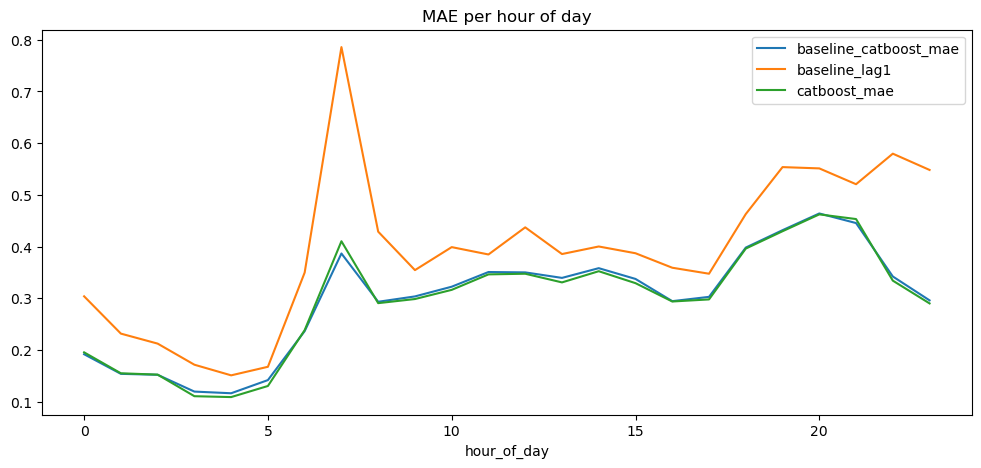

In [67]:
hourly_metric_df = resid_df[
    (resid_df['subset'] == 'test') &
    (resid_df['model_name'].isin(['baseline_lag1', 'baseline_catboost_mae', 'catboost_mae']))
]
hourly_metric_df['hour_of_day'] = hourly_metric_df['hour'].dt.hour
hourly_metric_df = hourly_metric_df.groupby(['model_name', 'hour_of_day'])['abs_resid'].mean().unstack(level=1).T
fig, ax = plt.subplots(figsize=(12, 5))
for col in hourly_metric_df.columns:
    hourly_metric_df[col].plot(ax=ax, label=col)
plt.legend()
plt.title('MAE per hour of day')
plt.show()

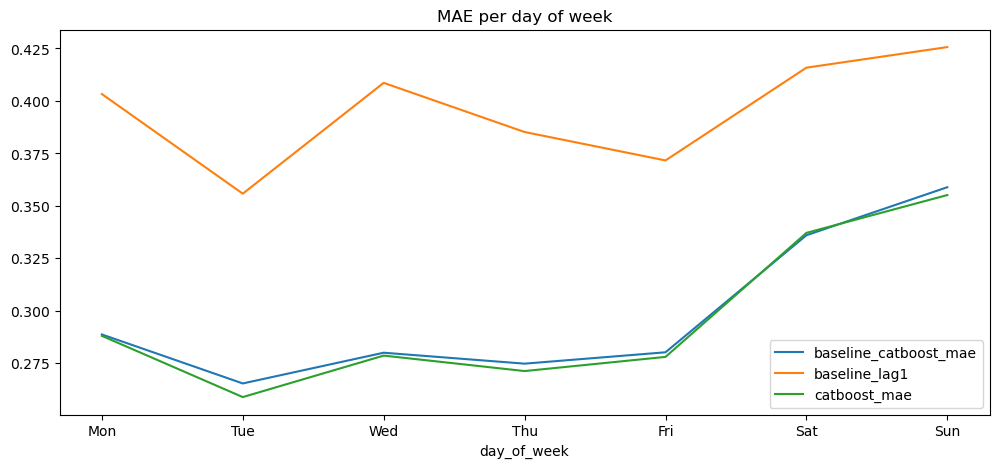

In [73]:
daily_metric_df = resid_df[
    (resid_df['subset'] == 'test') &
    (resid_df['model_name'].isin(['baseline_lag1', 'baseline_catboost_mae', 'catboost_mae']))
]
daily_metric_df['day_of_week'] = daily_metric_df['hour'].dt.day_of_week
daily_metric_df = daily_metric_df.groupby(['model_name', 'day_of_week'])['abs_resid'].mean().unstack(level=1).T
fig, ax = plt.subplots(figsize=(12, 5))
for col in daily_metric_df.columns:
    daily_metric_df[col].plot(ax=ax, label=col)
plt.legend()
plt.title('MAE per day of week')
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

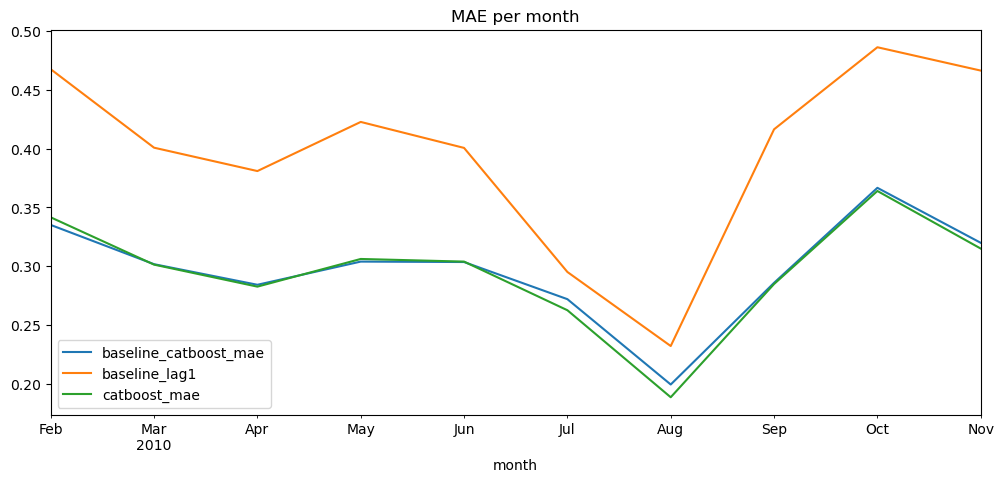

In [69]:
monthly_metric_df = resid_df[
    (resid_df['subset'] == 'test') &
    (resid_df['model_name'].isin(['baseline_lag1', 'baseline_catboost_mae', 'catboost_mae']))
]
monthly_metric_df['month'] = monthly_metric_df['hour'].dt.to_period('M').dt.to_timestamp()
monthly_metric_df = monthly_metric_df.groupby(['model_name', 'month'])['abs_resid'].mean().unstack(level=1).T
fig, ax = plt.subplots(figsize=(12, 5))
for col in monthly_metric_df.columns:
    monthly_metric_df[col].plot(ax=ax, label=col)
plt.legend()
plt.title('MAE per month')
plt.show()

Here we break down MAE on test with respect to time interval, as model error is not uniform over time.

MAE has two daily peaks: early morning (post-night transition) and evening (return-home hours).

MAE for catboost models is noticeably higher on weekends than weekdays.

Monthly MAE covers Feb–Nov: it trends down into August and rises again toward October, consistent with a seasonal regime shift in consumption patterns.